# 0. 프로젝트 기획

딥러닝
자연어처리(NLP)
감성 분석
다중 감성 분석

데이터 : AIhub 감성 대화 말뭉치

# 1. 데이터 전처리 및 EDA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

train = pd.read_excel("/content/drive/MyDrive/코드스테이츠/Section4/Project/data/감성대화말뭉치(최종데이터)_Training.xlsx")

In [4]:
val = pd.read_excel("/content/drive/MyDrive/코드스테이츠/Section4/Project/data/감성대화말뭉치(최종데이터)_Validation.xlsx")

In [5]:
train.head()

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.
3,31303,노년,남성,재정,만성질환 무,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...,이 기분을 유지하려면 어떻게 해야 할까요?,회사생활을 열심히 해서 계속 월급을 받을거야!,계속 원하시는 대로 회사생활이 이어지길 바랄게요.,NaN,NaN
4,47200,노년,여성,재정,만성질환 유,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶으시군요.,NaN,NaN,NaN,NaN


In [6]:
val.head()

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN
2,35590,청소년,남성,학교폭력/따돌림,해당없음,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,용기 있는 행동을 하셨네요. 마음이 어떠셨나요?,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,그랬군요. 지금 기분에서 벗어나기 위해 할 수 있는 일에는 무엇이 있을까요?,나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.,지금의 상황이 나의 방식으로써 잘 해결될 수 있기를 바라요.,NaN,NaN
3,169,청년,남성,"진로, 취업, 직장",해당없음,당황,죄책감의,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이야.,팀장님이 부탁하신 업무를 잘못 처리하셔서 많이 당황하시고 놀라셨겠어요.,곧 있으면 인턴에서 정규직 전환 평가가 있는데 안 좋을 것 같아.,마음이 많이 안 좋으시겠어요. 지금 상황을 타개할 수 있는 가장 좋은 방안이 있을까요?,우선 잘못된 부분을 솔직하게 말씀드리고 수정하기 위해서 최선을 다해봐야겠어.,잘못된 부분을 잘 수정해서 좋은 결과가 있었으면 좋겠어요.,NaN,NaN
4,38435,중년,여성,"재정, 은퇴, 노후준비",해당없음,분노,노여워하는,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어.,많이 화가 나시겠어요.,어떻게 그럴 수가 있지? 너무 화가 나.,어떻게 하면 지금의 감정을 추스를 수 있을까요?,나도 변호사를 고용해서 한번 얘기해보려고 해.,자녀분들이랑 함께 하며 슬픔을 극복하시길 바라요.,NaN,NaN


In [5]:
# 두 개의 데이터를 concat해서 한번에 전처리 과정을 진행
# 추후 분리

df = pd.concat([train, val])

In [8]:
print(train.shape, val.shape)

(40879, 15) (5130, 15)


In [9]:
df.head()

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.
3,31303,노년,남성,재정,만성질환 무,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...,이 기분을 유지하려면 어떻게 해야 할까요?,회사생활을 열심히 해서 계속 월급을 받을거야!,계속 원하시는 대로 회사생활이 이어지길 바랄게요.,NaN,NaN
4,47200,노년,여성,재정,만성질환 유,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶으시군요.,NaN,NaN,NaN,NaN


In [6]:
# input을 '사람문장1'(감정이 들어간 문장), output을 '감정_대분류'로 설정

df = df[['사람문장1', '감정_대분류']]

In [7]:
df.reset_index(drop=True,inplace=True)

In [8]:
df.info() # Nan값 없음 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46009 entries, 0 to 46008
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   사람문장1   46009 non-null  object
 1   감정_대분류  46009 non-null  object
dtypes: object(2)
memory usage: 719.0+ KB


In [9]:
df['감정_대분류'].unique() # '불안 ' 및 '기쁨 ' 과 같이 공백이 껴있는 데이터 발견

array(['기쁨', '불안', '당황', '슬픔', '분노', '상처', '불안 ', '기쁨 '], dtype=object)

In [10]:
df['감정_대분류'] = df['감정_대분류'].apply(lambda x : x.rstrip())

In [11]:
df['감정_대분류'].unique()

array(['기쁨', '불안', '당황', '슬픔', '분노', '상처'], dtype=object)

In [12]:
df.columns = ['sentence', 'label']

In [13]:
df.head()

,sentence,label
0,아내가 드디어 출산하게 되어서 정말 신이 나.,기쁨
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,불안
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,당황
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,기쁨
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기쁨


In [100]:
# 시각화 시 한글 폰트 설정

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49256 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48520 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50504 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45817 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54889 missing from current font.
  font.set_

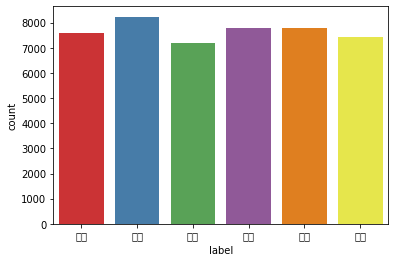

In [101]:
# 데이터 6개의 라벨값 균형 확인

import seaborn as sns

sns.countplot(x='label', data=df, palette='Set1');

# 2. 텍스트 전처리
- regex 전처리
- 형태소 분석기를 이용한 token화
- 불용어 사전을 이용한 불용어 제거

## 2-1. regex 전처리

In [16]:
# regex를 이용하여 한국말 이외의 문자열 제거(영어, 특수문자, 구두점 등)

df['sentence'] = df['sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
df.head()

,sentence,label
0,아내가 드디어 출산하게 되어서 정말 신이 나,기쁨
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,불안
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,당황
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 너무 행복해,기쁨
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어,기쁨


## 2-2. Tokenizer(형태소 분석기 이용)

In [ ]:
# !pip install konlpy

In [ ]:
# from konlpy.tag import Kkma

# kkma = Kkma()

# df['sentence'].apply(lambda x : kkma.morphs(x))

In [18]:
# Mecab을 포함한 konlpy 설치

!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-03-18 04:56:31--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-03-18 04:56:32--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf3b8e066849b5604cede4613ce.dl.dropboxusercontent.com/cd/0/get/BhpCdVe_5omsWbHm9bJE2XjuDodt-nuEfiEEnWjAJqX7gQXm1QbGFVmx3F1X3f7hjmozYHyLqWmhEWJnjq3Yu9I_VNIfHRvc7Ny73x0jaidiuJBrYzzV0Q1u7nKpXST9ZbkR3M0diKmCVusDgzYaTD_rDtg5ZdmQm_GvByTl_yCsBDHsQV4Euue4u4wjllSyfhE/file?dl=1# [following]
--2022-03-18 04:56:32--  https://ucf3b8e066849b5604cede4613ce.dl.dropboxusercontent.com/cd/0/get/

In [145]:
from konlpy.tag import Hannanum, Kkma, Komoran, Mecab, Okt

han = Hannanum()
kkma = Kkma()
komo = Komoran()
mecab = Mecab()
okt = Okt()

# 형태소 분석기 별 형태소 단위 토큰화 테스트

for tokenizer in [han, kkma, komo, mecab]:
    print(tokenizer.morphs(df['sentence'][0]))
print(okt.morphs(df['sentence'][0], stem=True)) # okt의 경우 stemming 기능 제공

['아내', '가', '드디어', '출산', '하', '게', '되', '어서', '정말', '신', '이', '나']
['아내', '가', '드디어', '출산', '하', '게', '되', '어서', '정말', '신이', '나']
['아내', '가', '드디어', '출산', '하', '게', '되', '어서', '정말', '신이', '나']
['아내', '가', '드디어', '출산', '하', '게', '되', '어서', '정말', '신', '이', '나']
['아내', '가', '드디어', '출산', '하다', '되어다', '정말', '신', '이', '나']


In [107]:
# 형태소 분석기 별 품사 태깅 단위 토큰화 테스트

for tokenizer in [han, kkma, komo, mecab, okt]:
    print(tokenizer.pos(df['sentence'][0]))

[('아내', 'N'), ('가', 'J'), ('드디어', 'M'), ('출산', 'N'), ('하', 'X'), ('게', 'E'), ('되', 'P'), ('어서', 'E'), ('정말', 'M'), ('신', 'N'), ('이', 'J'), ('나', 'N')]
[('아내', 'NNG'), ('가', 'JKS'), ('드디어', 'MAG'), ('출산', 'NNG'), ('하', 'XSV'), ('게', 'ECD'), ('되', 'VV'), ('어서', 'ECD'), ('정말', 'MAG'), ('신이', 'NNG'), ('나', 'NNG')]
[('아내', 'NNG'), ('가', 'JKS'), ('드디어', 'MAG'), ('출산', 'NNG'), ('하', 'XSV'), ('게', 'EC'), ('되', 'VV'), ('어서', 'EC'), ('정말', 'MAG'), ('신이', 'NNP'), ('나', 'NP')]
[('아내', 'NNG'), ('가', 'JKS'), ('드디어', 'MAG'), ('출산', 'NNG'), ('하', 'XSV'), ('게', 'EC'), ('되', 'VV'), ('어서', 'EC'), ('정말', 'MAG'), ('신', 'NNG'), ('이', 'JKS'), ('나', 'VV+EC')]
[('아내', 'Noun'), ('가', 'Josa'), ('드디어', 'Adverb'), ('출산', 'Noun'), ('하게', 'Verb'), ('되어서', 'Verb'), ('정말', 'Noun'), ('신', 'Noun'), ('이', 'Josa'), ('나', 'Noun')]


In [108]:
# 형태소 분석기 별 명사 태깅 단위 토큰화 테스트

for tokenizer in [han, kkma, komo, mecab, okt]:
    print(tokenizer.nouns(df['sentence'][0]))

['아내', '출산', '신', '나']
['아내', '출산', '신이', '나']
['아내', '출산', '신이']
['아내', '출산', '신']
['아내', '출산', '정말', '신', '나']


In [227]:
# 형태소 단위로 토큰화

df['sentence_tokenized'] = df['sentence'].apply(lambda x : mecab.morphs(x))

In [228]:
df.head()

,sentence,label,sentence_tokenized
0,아내가 드디어 출산하게 되어서 정말 신이 나,기쁨,"[아내, 가, 드디어, 출산, 하, 게, 되, 어서, 정말, 신, 이, 나]"
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,불안,"[당뇨, 랑, 합병증, 때문, 에, 먹, 어야, 할, 약, 이, 열, 가지, 가, ..."
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,당황,"[고등학교, 에, 올라오, 니, 중학교, 때, 보다, 수업, 이, 갑자기, 어려워져..."
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 너무 행복해,기쁨,"[재취업, 이, 돼서, 받, 게, 된, 첫, 월급, 으로, 온, 가족, 이, 외식,..."
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어,기쁨,"[빚, 을, 드디어, 다, 갚, 게, 되, 어서, 이제야, 안도감, 이, 들, 어]"


## 2-3. 불용어 제거 token 만들기

In [151]:
stop_words_1 = pd.read_table('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/한국어불용어100.txt', header=None) # https://bab2min.tistory.com/544#google_vignette

In [152]:
stop_words_2 = pd.read_csv('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/한국어불용어(rank_nl_stopwords_korean).txt', header=None) # https://www.ranks.nl/stopwords/korean

In [153]:
stop_words_1 = stop_words_1[[0]]

In [154]:
stop_words_1.head()

,0
0,이
1,있
2,하
3,것
4,들


In [155]:
stop_words_2.head()

,0
0,아
1,휴
2,아이구
3,아이쿠
4,아이고


In [156]:
print(stop_words_1.shape, stop_words_2.shape)

(100, 1) (691, 1)


In [157]:
stop_words = pd.concat([stop_words_1, stop_words_2])

In [158]:
stop_words.drop_duplicates(subset=[0], inplace=True)

In [159]:
stop_words.reset_index(drop=True, inplace=True)

In [160]:
import numpy as np

stop_words = np.array(stop_words[0])

In [161]:
df.columns

Index(['sentence', 'label', 'mecab_morphs', 'okt_morphs', 'mecab_nouns',
       'okt_nouns'],
      dtype='object')

In [229]:
# 형태소 단위 토큰화에서 불용어 제거

temp = []

for tokens in df['sentence_tokenized']:
    temp.append([token for token in tokens if token not in stop_words])

df['sentence_tokenized'] = temp

In [230]:
df.head()

,sentence,label,sentence_tokenized
0,아내가 드디어 출산하게 되어서 정말 신이 나,기쁨,"[아내, 드디어, 출산, 어서, 정말, 신]"
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,불안,"[당뇨, 랑, 합병증, 먹, 어야, 할, 약, 열, 넘어가, 스트레스]"
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,당황,"[고등학교, 올라오, 니, 중학교, 보다, 수업, 갑자기, 어려워져서, 당황, 스러워]"
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 너무 행복해,기쁨,"[재취업, 돼서, 된, 첫, 월급, 온, 가족, 외식, 할, 예정, 너무, 행복]"
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어,기쁨,"[빚, 드디어, 갚, 어서, 이제야, 안도감]"


In [232]:
df['sentence_tokenized'][0][0]

'아내'

In [240]:
# tokinze까지 완료, 중간 저장
# df.to_csv()로 저장하는 경우, dataframe내의 list 개체가 문자열처리가 되어버림
# pickle을 통하면 자료 type을 유지한채로 저장 가능
df.to_pickle('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/data_token.pkl')

In [246]:
df = pd.read_pickle('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/data_token.pkl')

In [247]:
df.head()

,sentence,label,sentence_tokenized
0,아내가 드디어 출산하게 되어서 정말 신이 나,기쁨,"[아내, 드디어, 출산, 어서, 정말, 신]"
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,불안,"[당뇨, 랑, 합병증, 먹, 어야, 할, 약, 열, 넘어가, 스트레스]"
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,당황,"[고등학교, 올라오, 니, 중학교, 보다, 수업, 갑자기, 어려워져서, 당황, 스러워]"
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 너무 행복해,기쁨,"[재취업, 돼서, 된, 첫, 월급, 온, 가족, 외식, 할, 예정, 너무, 행복]"
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어,기쁨,"[빚, 드디어, 갚, 어서, 이제야, 안도감]"


#### Count 해보기(삭제 예정)

In [135]:
from collections import Counter

# Counter 객체는 리스트요소의 값과 요소의 갯수를 카운트 하여 저장하고 있습니다.
# 카운터 객체는 .update 메소드로 계속 업데이트 가능합니다.

def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴합니다.
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 문서에 단어가 존재하느냐 안하느냐, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [137]:
wc = word_count(df['token_morphs_no_stop'])
wc.head()

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
29,너무,8747,8943,1.0,0.025211,0.025211,0.190115
67,친구,7629,8422,2.0,0.023742,0.048953,0.165815
47,었,3728,3881,3.0,0.010941,0.059893,0.081028
98,해서,3437,3502,4.0,0.009872,0.069766,0.074703
55,만,3098,3239,5.0,0.009131,0.078896,0.067335


In [138]:
wc = word_count(df['token_morphs'])
wc.head()

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
2,이,24055,31105,1.0,0.040529,0.040529,0.522832
6,가,19380,23715,2.0,0.030900,0.071430,0.421222
55,어,20177,22316,3.0,0.029077,0.100507,0.438545
40,을,16164,19090,4.0,0.024874,0.125381,0.351323
7,하,14054,16874,5.0,0.021987,0.147367,0.305462


In [139]:
wc = word_count(df['token_nouns'])
wc.head()

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
42,나,10588,11582,1.0,0.049230,0.049230,0.230129
41,친구,7629,8422,2.0,0.035798,0.085028,0.165815
27,내,7724,8192,3.0,0.034820,0.119848,0.167880
93,것,5188,5415,4.0,0.023017,0.142865,0.112761
81,일,3101,3287,5.0,0.013972,0.156837,0.067400


# 3. 벡터화(Vectorize)
- Word2Vec
- Glove
- FastText

## 3-1. Word2Vec

In [ ]:
from gensim.models.word2vec import Word2Vec

